# NLP, Reddit, over_18 prediction, v.3
Бинарная классификация (до и после 18) постов с сайта реддит по темам.

[Anton Petrov](mailto:anton.a.petrov@gmail.com), 2020

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
from tqdm.auto import tqdm
import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.style as style
style.use('fivethirtyeight')
# from sklearn.metrics import plot_roc_curve
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

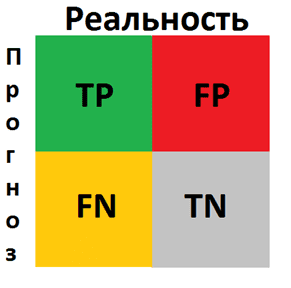

In [75]:
def show_conf_matrix(y_test, predictions):
  plt.figure(figsize=(5,5))
  con_mat = confusion_matrix(y_test, predictions)
  sns.heatmap(con_mat, annot=True, fmt=".3f", square=True, cmap="Greens")
  plt.xlabel('Правильный ответ')
  plt.ylabel('Прогноз модели')

# Для справки, чтобы не запутаться с результатами обучения модели
from IPython.display import Image
Image(filename='conf_matrix.png') 

In [7]:
data = pd.read_csv("./data/r_dataisbeautiful_posts.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data.head()

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,hbyv2e,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,NaN,NaN,0.0,[],1592565317,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,hbynoy,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,NaN,NaN,0.0,[],1592564316,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
2,hbym2y,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,NaN,NaN,0.0,[],1592564089,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
3,hbyirw,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,NaN,moderator,0.0,[],1592563628,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,hby1fy,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,Viz Researcher,NaN,0.0,[],1592561119,https://www.reddit.com/r/dataisbeautiful/comme...,2,False


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183891 entries, 0 to 183890
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     183891 non-null  object 
 1   title                  183890 non-null  object 
 2   score                  183891 non-null  int64  
 3   author                 183891 non-null  object 
 4   author_flair_text      24574 non-null   object 
 5   removed_by             11564 non-null   object 
 6   total_awards_received  44007 non-null   float64
 7   awarders               33332 non-null   object 
 8   created_utc            183891 non-null  int64  
 9   full_link              183891 non-null  object 
 10  num_comments           183891 non-null  int64  
 11  over_18                183891 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 15.6+ MB


In [11]:
# смотрим пропуски в процентах
(data.isnull().sum() / len(data)) * 100

id                        0.000000
title                     0.000544
score                     0.000000
author                    0.000000
author_flair_text        86.636649
removed_by               93.711492
total_awards_received    76.068976
awarders                 81.874045
created_utc               0.000000
full_link                 0.000000
num_comments              0.000000
over_18                   0.000000
dtype: float64

In [12]:
del data['id']
del data['author_flair_text']
del data['removed_by']
del data['total_awards_received']
del data['awarders']
del data['created_utc']
del data['full_link']

In [13]:
data = data.dropna()
data.head()

,title,score,author,num_comments,over_18
0,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,0,False
1,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,1,False
2,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,1,False
3,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,0,False
4,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,2,False


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183890 entries, 0 to 183890
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         183890 non-null  object
 1   score         183890 non-null  int64 
 2   author        183890 non-null  object
 3   num_comments  183890 non-null  int64 
 4   over_18       183890 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 7.2+ MB


In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
score,183890.0,186.653146,1969.840789,0.0,1.0,1.0,5.0,116226.0
num_comments,183890.0,25.382386,195.623099,0.0,1.0,1.0,4.0,18801.0


In [17]:
len(data)

183890

## Чистка данных

In [20]:
def remove_hyperlinks(text):
  return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)


def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(' ', token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

  
def remove_special_characters(text):
    return re.sub('[^a-zA-z0-9\s]', '', text)

  
def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

  
def remove_line_breaks(text):
    return text.replace('\r', ' ').replace('\n', ' ')

  
def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    return " ".join([word for word in word_tokens if word not in stop])

def remove_one_character_words(text):
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    

def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

  
def lemmatize(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)

  
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
  
  
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    


def tokenize(text):
    return re.findall(r'\w+', text)

  
def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)

  
def preprocess_text(text):
    operations = [
      # remove_hyperlinks
      remove_line_breaks,
      remove_one_character_words,
      remove_special_characters,
      lowercase,
      remove_punctuation,
      remove_stopwords,
      stem,
      remove_numbers
    ]
    for f in operations:
        text = f(text)
    return text   


In [24]:
data['clean_title'] = data['title'].progress_apply(preprocess_text)

100%|██████████| 183890/183890 [02:05<00:00, 1462.06it/s]


In [26]:
data['title']

0         [OC] How Bar Chart Race Animation Can be Creat...
1         [UK] Labour and Conservative vote share by age...
2         [NOC] Number of wallets returned across the wo...
3         Largest Banana Producing Countries (1961-2020)...
4         [OC] Popular Combinations for the StamiStudios...
                                ...                        
183886             Infosthetics seems like it belongs here.
183887    Time lapse of every nuclear detonation from 19...
183888                                              Wavii. 
183889    An interactive representation of Pres. Obamas ...
183890    A map showing the geographical distribution of...
Name: title, Length: 183890, dtype: object

In [27]:
words = data["clean_title"].values
words

array(['oc bar chart race anim creat covid confirm case built automat adob effect',
       'uk labour conserv vote share age group ',
       'noc number wallet return across world', ..., 'wavii',
       'interact represent pres obama  budget propos',
       'map show geograph distribut lactos intoler'], dtype=object)

In [30]:
word_list = []

for i in words:
    word_list.append(str(i))

In [31]:
word_list[:10]

['oc bar chart race anim creat covid confirm case built automat adob effect',
 'uk labour conserv vote share age group ',
 'noc number wallet return across world',
 'largest banana produc countri  oc',
 'oc popular combin stamistudio everyday ita bag',
 'great wallet experi mani wallet return',
 'top  richest peopl world ',
 'oc youtub timelin visual show corona death around world',
 'take credit slight morbid interest anim',
 'behold ']

(-0.5, 1919.5, 1079.5, -0.5)

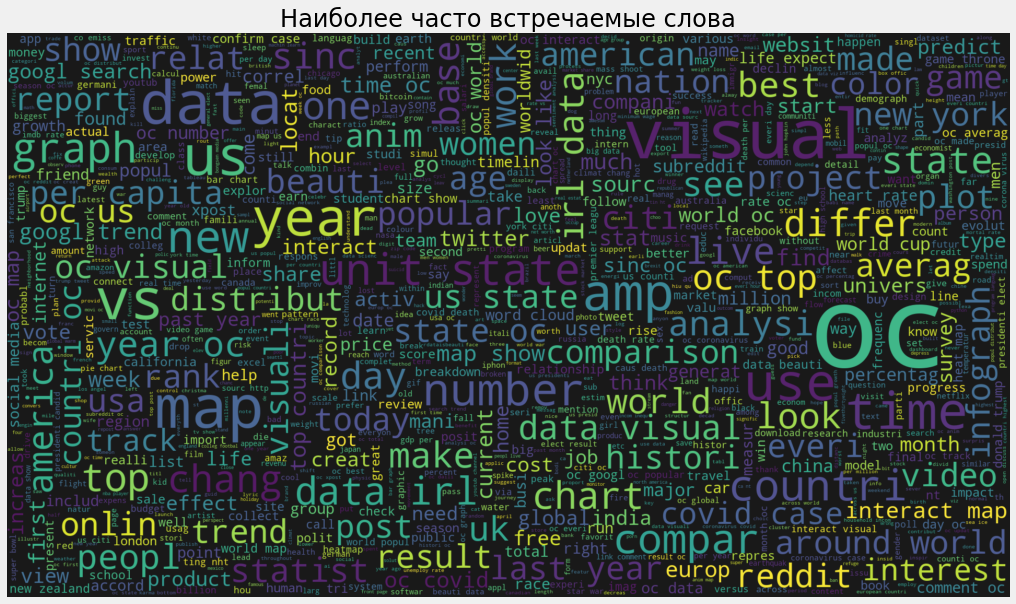

In [32]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=999, max_font_size= 220,  width=1920, height=1080)
wc.generate(" ".join(word_list))

plt.title("Наиболее часто встречаемые слова", fontsize=24)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=42), alpha=0.9, interpolation="bilinear", )
plt.axis('off')

In [33]:
data.head()

,title,score,author,num_comments,over_18,clean_title
0,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,0,False,oc bar chart race anim creat covid confirm cas...
1,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,1,False,uk labour conserv vote share age group
2,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,1,False,noc number wallet return across world
3,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,0,False,largest banana produc countri oc
4,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,2,False,oc popular combin stamistudio everyday ita bag


# РАБОТА С МОДЕЛЬЮ

## Работа с текстом

In [35]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
np.random.seed(2020)

In [36]:
stemmer = SnowballStemmer('english')

In [38]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [39]:
data['title'].iloc[1]

'[UK] Labour and Conservative vote share by age group 1992-2019'

In [40]:
document_sample = data['title'].iloc[1]

print('Оригинальный документ: ')
words = []
for word in document_sample.split(' '):
    words.append(word)
print(words)

print('\n\n Обработанный документ: ')
print(preprocess(document_sample))

Оригинальный документ: 
['[UK]', 'Labour', 'and', 'Conservative', 'vote', 'share', 'by', 'age', 'group', '1992-2019']


 Обработанный документ: 
['labour', 'conserv', 'vote', 'share', 'group']


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183890 entries, 0 to 183890
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         183890 non-null  object
 1   score         183890 non-null  int64 
 2   author        183890 non-null  object
 3   num_comments  183890 non-null  int64 
 4   over_18       183890 non-null  bool  
 5   clean_title   183890 non-null  object
dtypes: bool(1), int64(2), object(3)
memory usage: 8.6+ MB


In [42]:
data['clean_title'] = data['clean_title'].astype(str)

In [44]:
words = []
for i in data['clean_title']:
        words.append(i.split(' '))
words

[['oc',
  'bar',
  'chart',
  'race',
  'anim',
  'creat',
  'covid',
  'confirm',
  'case',
  'built',
  'automat',
  'adob',
  'effect'],
 ['uk', 'labour', 'conserv', 'vote', 'share', 'age', 'group', ''],
 ['noc', 'number', 'wallet', 'return', 'across', 'world'],
 ['largest', 'banana', 'produc', 'countri', '', 'oc'],
 ['oc', 'popular', 'combin', 'stamistudio', 'everyday', 'ita', 'bag'],
 ['great', 'wallet', 'experi', 'mani', 'wallet', 'return'],
 ['top', '', 'richest', 'peopl', 'world', ''],
 ['oc',
  'youtub',
  'timelin',
  'visual',
  'show',
  'corona',
  'death',
  'around',
  'world'],
 ['take', 'credit', 'slight', 'morbid', 'interest', 'anim'],
 ['behold', ''],
 ['measur', 'honesti', 'wallet', 'experi'],
 ['oc', 'religi', 'makeup', 'us', 'hous', 'repres'],
 ['spread', 'covid', 'washington', 'state', 'oc'],
 ['religi', 'makeup', 'us', 'hous', 'repres'],
 ['oc', 'religi', 'makeup', 'us', 'hous', 'repres'],
 ['oc',
  'corpor',
  'pigsti',
  'lpl',
  'financi',
  'servic',
  'fine

### Словарь уникальных слов в колонке 'title'

In [46]:
dictionary = gensim.corpora.Dictionary(words)

# вывести содержимое словаря...
count = 0
for key, value in dictionary.iteritems():
    print(key, ': ', value)
    count += 1
    if count > 100:
        break

0 :  adob
1 :  anim
2 :  automat
3 :  bar
4 :  built
5 :  case
6 :  chart
7 :  confirm
8 :  covid
9 :  creat
10 :  effect
11 :  oc
12 :  race
13 :  
14 :  age
15 :  conserv
16 :  group
17 :  labour
18 :  share
19 :  uk
20 :  vote
21 :  across
22 :  noc
23 :  number
24 :  return
25 :  wallet
26 :  world
27 :  banana
28 :  countri
29 :  largest
30 :  produc
31 :  bag
32 :  combin
33 :  everyday
34 :  ita
35 :  popular
36 :  stamistudio
37 :  experi
38 :  great
39 :  mani
40 :  peopl
41 :  richest
42 :  top
43 :  around
44 :  corona
45 :  death
46 :  show
47 :  timelin
48 :  visual
49 :  youtub
50 :  credit
51 :  interest
52 :  morbid
53 :  slight
54 :  take
55 :  behold
56 :  honesti
57 :  measur
58 :  hous
59 :  makeup
60 :  religi
61 :  repres
62 :  us
63 :  spread
64 :  state
65 :  washington
66 :  appointe
67 :  charg
68 :  corpor
69 :  donald
70 :  elect
71 :  financi
72 :  fine
73 :  https
74 :  lpl
75 :  pigsti
76 :  regulatori
77 :  sec
78 :  servic
79 :  trump
80 :  wwwfinancial

Видим проблему с гиперссылками, потребуется их очистка (пока отложим)
80 :  wwwfinancialplanningcomnewslplfinedmillionfornotreportingcomplaintssuspiciousact


In [47]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


## Создаем корпус

Используем doc2bow для создания sparse vector.

In [49]:
bow_corpus = [dictionary.doc2bow(doc) for doc in words]
bow_corpus[1234]

[(11, 1), (27, 1), (37, 1), (422, 1), (629, 1), (1821, 1)]

In [50]:
bow_document = bow_corpus[1234]

for i in range(len(bow_document)):
    print("Слово {} (\"{}\") появляется {} раз.".format(bow_document[i][0], dictionary[bow_document[i][0]], 
bow_document[i][1]))

Слово 11 ("oc") появляется 1 раз.
Слово 27 ("countri") появляется 1 раз.
Слово 37 ("peopl") появляется 1 раз.
Слово 422 ("name") появляется 1 раз.
Слово 629 ("african") появляется 1 раз.
Слово 1821 ("memori") появляется 1 раз.


## TF/IDF

In [51]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.4111059774225314),
 (1, 0.24260708328162034),
 (2, 0.39846129335602937),
 (3, 0.28515423084240665),
 (4, 0.34080972436107215),
 (5, 0.22017439890517662),
 (6, 0.19549937209478796),
 (7, 0.2837106105120418),
 (8, 0.19093908300657628),
 (9, 0.255751245603694),
 (10, 0.27633112591352066),
 (11, 0.05715455651920538),
 (12, 0.25926361895393946)]


In [52]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=8)

## Вывод модели

In [71]:
for idx, topic in lda_model.print_topics(-1):
    print('Тема: {} Слово: {}'.format(idx, topic))

Тема: 0 Слово: 0.051*"oc" + 0.020*"game" + 0.019*"" + 0.015*"rate" + 0.011*"onlin" + 0.011*"https" + 0.010*"visual" + 0.009*"movi" + 0.008*"incom" + 0.007*"money"
Тема: 1 Слово: 0.063*"" + 0.058*"oc" + 0.027*"map" + 0.021*"covid" + 0.021*"popul" + 0.018*"us" + 0.013*"world" + 0.012*"death" + 0.012*"case" + 0.012*"interact"
Тема: 2 Слово: 0.047*"data" + 0.024*"oc" + 0.024*"visual" + 0.012*"irl" + 0.011*"show" + 0.010*"make" + 0.010*"world" + 0.010*"graph" + 0.009*"chart" + 0.007*"xpost"
Тема: 3 Слово: 0.058*"oc" + 0.052*"" + 0.015*"year" + 0.014*"state" + 0.014*"new" + 0.012*"day" + 0.012*"month" + 0.011*"citi" + 0.010*"hour" + 0.010*"time"
Тема: 4 Слово: 0.060*"oc" + 0.033*"" + 0.015*"state" + 0.012*"elect" + 0.012*"us" + 0.011*"year" + 0.011*"map" + 0.009*"america" + 0.009*"vote" + 0.008*"name"
Тема: 5 Слово: 0.067*"" + 0.050*"oc" + 0.024*"countri" + 0.014*"us" + 0.013*"state" + 0.012*"year" + 0.012*"top" + 0.012*"trump" + 0.010*"time" + 0.009*"rate"
Тема: 6 Слово: 0.129*"" + 0.053*"o

In [72]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=8)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Тема: {} Слово: {}'.format(idx, topic))

Тема: 0 Слово: 0.014*"oc" + 0.013*"" + 0.010*"word" + 0.009*"languag" + 0.006*"leagu" + 0.006*"visual" + 0.005*"world" + 0.005*"reddit" + 0.005*"map" + 0.005*"use"
Тема: 1 Слово: 0.013*"" + 0.010*"oc" + 0.008*"elect" + 0.007*"presidenti" + 0.007*"googl" + 0.006*"visual" + 0.005*"map" + 0.005*"music" + 0.005*"us" + 0.005*"de"
Тема: 2 Слово: 0.067*"" + 0.011*"oc" + 0.009*"year" + 0.009*"top" + 0.007*"world" + 0.006*"nba" + 0.006*"facebook" + 0.006*"social" + 0.005*"everi" + 0.005*"http"
Тема: 3 Слово: 0.018*"" + 0.012*"us" + 0.011*"oc" + 0.011*"popul" + 0.010*"world" + 0.009*"countri" + 0.008*"per" + 0.008*"state" + 0.007*"map" + 0.007*"rate"
Тема: 4 Слово: 0.042*"data" + 0.031*"irl" + 0.013*"beauti" + 0.010*"visual" + 0.009*"oc" + 0.009*"" + 0.006*"interest" + 0.006*"olymp" + 0.005*"world" + 0.005*"map"
Тема: 5 Слово: 0.019*"https" + 0.012*"" + 0.010*"oc" + 0.007*"incom" + 0.007*"us" + 0.006*"map" + 0.006*"energi" + 0.006*"visual" + 0.005*"data" + 0.005*"world"
Тема: 6 Слово: 0.009*"oc"

### Проверка предсказаний модели

In [54]:
document1 = 'To be, or not to be? That is the question...'
bow_vector = dictionary.doc2bow(preprocess(document1))

for index, score in sorted(lda_model[bow_vector], key=lambda t: -1*t[1]):
    print("Оценка: {}\t Заголовок: {}".format(score, lda_model.print_topic(index, 5)))

Оценка: 0.5499356389045715	 Заголовок: 0.047*"data" + 0.024*"oc" + 0.024*"visual" + 0.012*"irl" + 0.011*"show"
Оценка: 0.05001826956868172	 Заголовок: 0.051*"oc" + 0.020*"game" + 0.019*"" + 0.015*"rate" + 0.011*"onlin"
Оценка: 0.05001077800989151	 Заголовок: 0.045*"data" + 0.022*"oc" + 0.021*"map" + 0.017*"visual" + 0.015*"beauti"
Оценка: 0.05000742897391319	 Заголовок: 0.060*"oc" + 0.033*"" + 0.015*"state" + 0.012*"elect" + 0.012*"us"
Оценка: 0.05000581964850426	 Заголовок: 0.058*"oc" + 0.052*"" + 0.015*"year" + 0.014*"state" + 0.014*"new"
Оценка: 0.05000457540154457	 Заголовок: 0.067*"" + 0.050*"oc" + 0.024*"countri" + 0.014*"us" + 0.013*"state"
Оценка: 0.05000454559922218	 Заголовок: 0.100*"" + 0.039*"oc" + 0.027*"world" + 0.015*"peopl" + 0.013*"global"
Оценка: 0.05000447854399681	 Заголовок: 0.069*"oc" + 0.018*"" + 0.016*"vs" + 0.013*"time" + 0.011*"chart"
Оценка: 0.05000434070825577	 Заголовок: 0.129*"" + 0.053*"oc" + 0.019*"top" + 0.014*"us" + 0.012*"sinc"
Оценка: 0.0500041358172

## Предсказание 'over_18'

In [55]:
data['over_18'] = data['over_18'].astype(int)

In [56]:
data['over_18'] = pd.Categorical(data['over_18']) 

In [57]:
data['over_18']

0         0
1         0
2         0
3         0
4         0
         ..
183886    0
183887    0
183888    0
183889    0
183890    0
Name: over_18, Length: 183890, dtype: category
Categories (2, int64): [0, 1]

### Проверка сбалансированности классов

In [58]:
(data['over_18'].value_counts(normalize=True))

0    0.994872
1    0.005128
Name: over_18, dtype: float64

Класс 1 представлен в 0.5% случаях. Применим __resampling__ из пакета _sklearn.utils_

In [59]:
from sklearn.utils import resample

In [60]:
# 0: 0.994872
# 1: 0.005128

df_class_0 = data[data.over_18==0]
df_class_1 = data[data.over_18==1]
 
df_class_1_upsampled = resample(df_class_1, replace=True, n_samples=180000)
 
data_n = pd.concat([df_class_0, df_class_1_upsampled])
 
data_n['over_18'].value_counts()

0    182947
1    180000
Name: over_18, dtype: int64

In [61]:
(data_n['over_18'].value_counts(normalize=True))

0    0.50406
1    0.49594
Name: over_18, dtype: float64

In [62]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
processed_text = data_n['clean_title']
processed_text

0         oc bar chart race anim creat covid confirm cas...
1                   uk labour conserv vote share age group 
2                     noc number wallet return across world
3                         largest banana produc countri  oc
4            oc popular combin stamistudio everyday ita bag
                                ...                        
159849    porn categori watch via game consol imgur link...
35394                                oc  month tinder use f
18244                         oc experi tinder sinc januari
141206                       wright skincar skincar heritag
164744    chicago  day murder trend wound vs kill post j...
Name: clean_title, Length: 362947, dtype: object

## TF/IDF

In [64]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(processed_text)
print(tfidf.shape)
print('\n')
print(vectorizer.get_feature_names())


(362947, 50124)


['aa', 'aaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaf', 'aaag', 'aac', 'aachen', 'aadhar', 'aaeeoo', 'aaf', 'aafa', 'aagey', 'aahd', 'aailyah', 'aaj', 'aakhri', 'aalborg', 'aaliyah', 'aamc', 'aamir', 'aamphan', 'aamr', 'aan', 'aanbied', 'aanbiedingen', 'aanbod', 'aand', 'aantrekkelijk', 'aao', 'aapl', 'aaqylfuvh', 'aar', 'aarau', 'aarogya', 'aaron', 'aaronsb', 'aaronsojoun', 'aarp', 'aarup', 'aashiqui', 'aashirwad', 'aasim', 'aatish', 'aatishb', 'aatishbcomlik', 'aausar', 'aavaranaa', 'aay', 'aayega', 'ab', 'aba', 'abacaba', 'abajo', 'abandon', 'abandonedstolen', 'abandonwar', 'abang', 'abargenton', 'abat', 'abaya', 'abb', 'abba', 'abbc', 'abbcm', 'abbcom', 'abbey', 'abbigliamento', 'abbott', 'abbottabad', 'abbrev', 'abbrevi', 'abc', 'abcd', 'abd', 'abdomin', 'abdou', 'abduct', 'abdul', 'abduljabbar', 'abendkleid', 'aberdeen', 'aberoth', 'aberr', 'abertura', 'abhairth', 'abhishek', 'abid', 'abida', 'abigail', 'abil', 'abinitio', 'abio', 'abiti', 'abito', 'abl', 'ablat', 'ablet

In [85]:
tfidf

<362947x50124 sparse matrix of type '<class 'numpy.float64'>'
	with 2400798 stored elements in Compressed Sparse Row format>

In [65]:
data_n['over_18']

0         0
1         0
2         0
3         0
4         0
         ..
159849    1
35394     1
18244     1
141206    1
164744    1
Name: over_18, Length: 362947, dtype: category
Categories (2, int64): [0, 1]

In [66]:
y = data_n['over_18']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, test_size=0.2, random_state=42)

In [73]:
# Классификатор NB
nb = naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)

print("Наивный Байес. Метрика Accuracy ==> ", accuracy_score(predictions, y_test) * 100)
print(classification_report(predictions, y_test))


Наивный Байес. Метрика Accuracy ==>  94.77476236396197
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     35017
           1       0.97      0.93      0.95     37573

    accuracy                           0.95     72590
   macro avg       0.95      0.95      0.95     72590
weighted avg       0.95      0.95      0.95     72590



In [95]:
# написать predict по произвольным данным

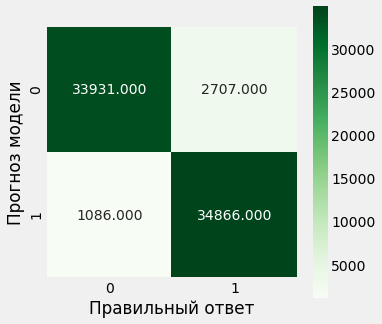

In [76]:
show_conf_matrix(y_test, predictions)

In [79]:
%%time

# значение max_iter=100 по умолчанию нас не устраивает, 
# т.к. модель ругается нехорошими словами, ей явно не хватает итераций, дадим ей max_iter=1000
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

predictions = lr.predict(X_test)

print("Логистическая регрессия. Метрика Accuracy ==> ",accuracy_score(predictions, y_test) * 100)
print(classification_report(predictions, y_test))

Логистическая регрессия. Метрика Accuracy ==>  98.36892133902741
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     36280
           1       0.99      0.98      0.98     36310

    accuracy                           0.98     72590
   macro avg       0.98      0.98      0.98     72590
weighted avg       0.98      0.98      0.98     72590

Wall time: 4.02 s


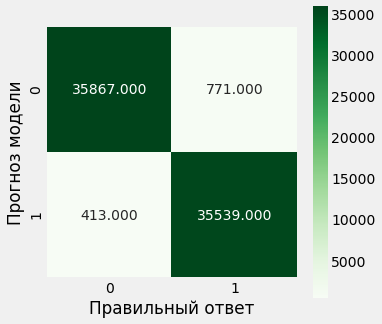

In [78]:
show_conf_matrix(y_test, predictions)